## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [2]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F
from torchvision.models import resnet18

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [26]:
class ImprovedModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
class ImprovedResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedResNet, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


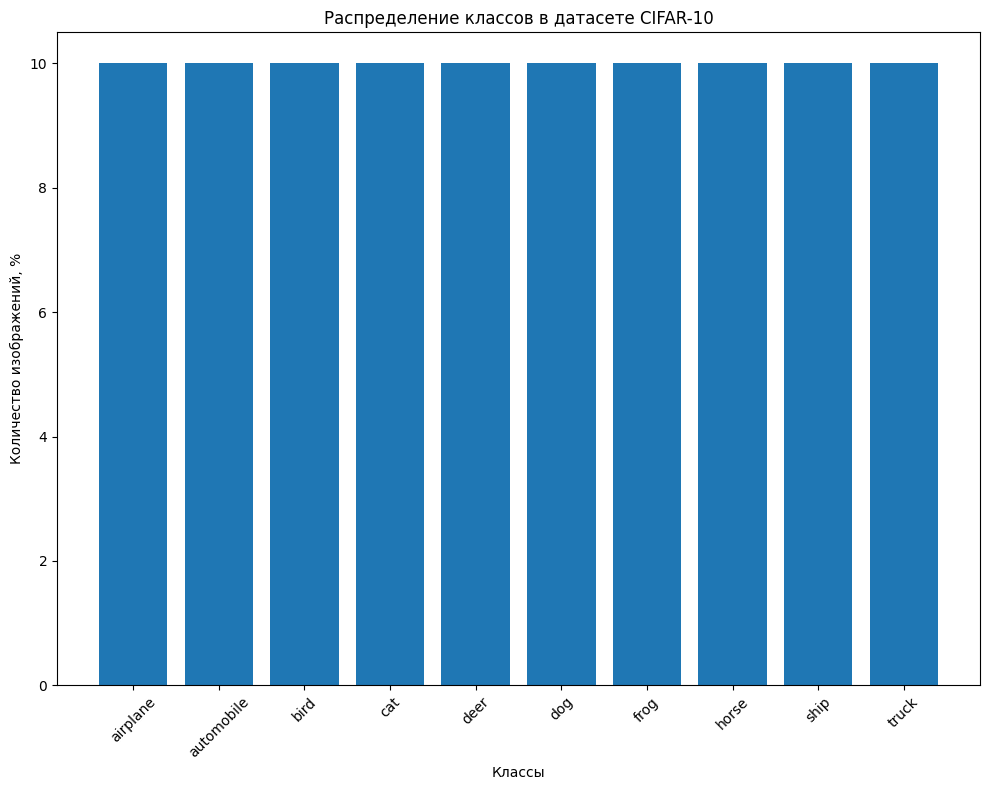

In [24]:
# Загрузка данных
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Распределение классов
class_labels = train_dataset.classes
class_counts = np.zeros(len(class_labels))
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

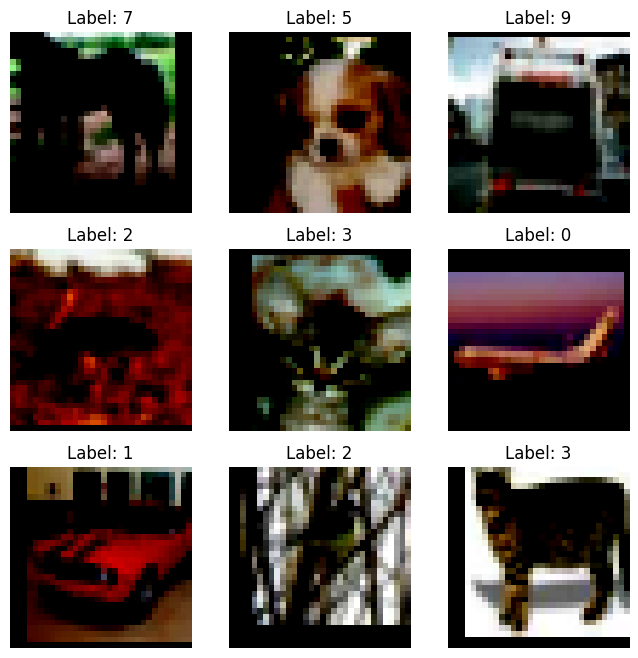

In [7]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:

На основе построенного графика распределения классов в наборе данных CIFAR-10 видно, что все 10 классов имеют примерно одинаковое количество изображений. Это свидетельствует о том, что датасет сбалансирован

Исходя из этого, какие метрики будем применять для оценки качества модели?

Так как датасет сбалансирован, метрики вроде Accuracy являются надежным показателем, поскольку в таких наборах данных каждая категория имеет примерно одинаковое количество примеров.

Напишем функции train и test

In [25]:
model = ImprovedModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / len(loader), 100. * correct / total

Сделайте разделение на train и val
Зачем так делать?

Разделение на train и validation нужно для объективной оценки качества модели на данных, не участвовавших в обучении, что помогает предотвратить переобучение. Val-набор используется для настройки гиперпараметров и контроля за тем, как модель будет работать с новыми данными.

In [9]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [27]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Обучите модель и постройте графики обучения

In [21]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/30:
    Train Loss: 1.2329, Train Accuracy: 55.67%
    Test Loss: 1.0074, Test Accuracy: 62.93%
Epoch 2/30:
    Train Loss: 1.1498, Train Accuracy: 59.02%
    Test Loss: 0.9135, Test Accuracy: 67.88%
Epoch 3/30:
    Train Loss: 1.0818, Train Accuracy: 62.19%
    Test Loss: 0.8617, Test Accuracy: 69.30%
Epoch 4/30:
    Train Loss: 1.0316, Train Accuracy: 63.92%
    Test Loss: 0.8335, Test Accuracy: 70.76%
Epoch 5/30:
    Train Loss: 0.9958, Train Accuracy: 65.10%
    Test Loss: 0.8092, Test Accuracy: 72.06%
Epoch 6/30:
    Train Loss: 0.9591, Train Accuracy: 66.44%
    Test Loss: 0.7438, Test Accuracy: 73.97%
Epoch 7/30:
    Train Loss: 0.9286, Train Accuracy: 67.74%
    Test Loss: 0.7815, Test Accuracy: 72.38%
Epoch 8/30:
    Train Loss: 0.9051, Train Accuracy: 68.48%
    Test Loss: 0.7032, Test Accuracy: 75.24%
Epoch 9/30:
    Train Loss: 0.8781, Train Accuracy: 69.56%
    Test Loss: 0.6898, Test Accuracy: 75.99%
Epoch 10/30:
    Train Loss: 0.8585, Train Accuracy: 70.53%
    

Оцените тестовую метрику на тестовых данных

In [23]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.5339
Test Accuracy: 0.8183


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов